In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = 'lfw'

In [3]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")

torch.Size([250, 250, 3])


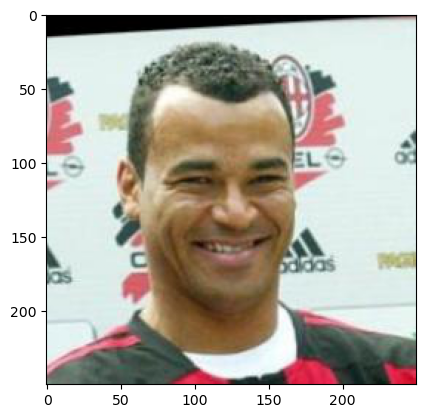

In [5]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

1. Applications:

AutoEncoders:

Used mostly for dimensionality reduction, feature extraction, and learning compressed data representations.
This is useful in applications like as denoising, where the AE learns to disregard noise in the input data.
AEs are frequently used for data compression, with the AE learning a compressed form of the input data.

AutoEncoders with Variations:

Used extensively in generative modeling. They have the ability to generate new data points that are comparable to the input data.
VAEs can generate new images that mimic a training dataset, which is useful in image production.
Used in disciplines such as semi-supervised learning, where the generative nature of VAEs can be used to enhance datasets.

2. Architecture:

AutoEncoders:

An encoder and a decoder are included.
The encoder compresses the input and converts it to a latent-space representation.
The output of this latent representation is reconstructed by the decoder.

AutoEncoders with Variations:

There is both an encoder and a decoder, but the latent space representation is different.
In VAEs, the encoder generates two values for each input: a mean and a variance (or log-variance).
These parameters denote a distribution from which a latent space vector is drawn. This sample adds randomness, which is important for generative models.


3. Loss Function:

AutoEncoders:

A reconstruction loss is often included in the loss function.
This loss quantifies how well the decoder's output corresponds to the original input.
Depending on the nature of the input data, common possibilities for this loss include Mean Squared Error (MSE) or Binary Cross-Entropy (BCE).

AutoEncoders with Variations:

In VAEs, the loss function combines reconstruction loss and a regularization term.
The reconstruction loss is identical to that in AEs, guaranteeing that the decoded samples correspond to the original inputs.

The regularization term is the Kullback-Leibler (KL) divergence, which measures how far the learnt distribution (defined by the encoder's mean and variance) deviates from a prior distribution (typically a standard normal distribution). This phrase motivates the model to learn efficient and robust data representations.


# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [6]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(3 * 250 * 250, 512) # Adjust input dimensions as needed
        self.fc21 = nn.Linear(512, 20)  # Mean of the latent space
        self.fc22 = nn.Linear(512, 20)  # Log variance of the latent space

        # Decoder
        self.fc3 = nn.Linear(20, 512)
        self.fc4 = nn.Linear(512, 250*250*3)  # Adjust output dimensions as needed

    def encode(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



## 1. Reparameterization Trick
The reparameterize function in your VAE plays a crucial role in the model's ability to perform well in generative tasks. Here's how it works:

Role of Reparameterization: Traditional autoencoders output a fixed vector in the latent space for a given input. VAEs, on the other hand, output a distribution (defined by mean mu and variance logvar) from which a latent vector is sampled. This sampling introduces randomness, crucial for generative models.

Implementation Detail:

std = torch.exp(0.5 * logvar): 

This line computes the standard deviation from the log variance. The log variance is used for numerical stability (it's more stable to store and exponentiate log variance than to store variance directly).

eps = torch.randn_like(std): Generates a tensor of random values from a standard normal distribution, which has the same shape as std.

return mu + eps * std: This line is the actual reparameterization trick. Instead of sampling directly from the distribution defined by mu and logvar, which would be non-differentiable and thus unsuitable for backpropagation, you sample from a standard normal distribution (eps) and scale and shift this sample by std and mu. This allows the network to backpropagate through the random sampling process by treating eps as an input noise vector.

## 2. The Decoder and Its Role in Generation

The decoder part of your VAE, defined in the decode function, is responsible for generating data points from the latent space representations:

Process:

The latent vector z, sampled in the reparameterize function, is passed to the first fully connected layer self.fc3, followed by a ReLU activation function.
The output of this layer is then passed through another fully connected layer self.fc4.
The final output is obtained by applying a sigmoid function, which is common in generative tasks, especially when the data points (like pixels in an image) are normalized between 0 and 1.

Significance in VAEs:

The decoder learns to map the latent space vectors back to the data space. For a well-trained VAE, this means that latent vectors (whether they are encodings of real data or sampled from the latent space distribution) should be decoded into realistic and plausible data points.
In the context of image generation, the decoder learns to construct images from latent representations, which should resemble the distribution of the original dataset.

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

In [7]:
import torch.nn.functional as F

# Assuming the VAE class is defined as provided
model = VAE().to(device)

dataiter = iter(dataloader)
images, _ = next(dataiter)
images = images.to(device)

# Make sure model is in evaluation mode
model.eval()

# Processing a single image
image = images[0].unsqueeze(0)  # Add batch dimension

# Forward pass through the model
with torch.no_grad():
    reconstructed, mu, logvar = model(image)

    print("Shape of the encoder's output (mu):", mu.shape)
    print("Shape of the encoder's output (logvar):", logvar.shape)

    # Generate new samples in the latent space and decode them
    samples = model.reparameterize(mu, logvar)
    print("Shape of the samples in the latent space:", samples.shape)

    generated_images = model.decode(samples)
    print("Shape of the decoder's output (generated images):", generated_images.shape)


Shape of the encoder's output (mu): torch.Size([1, 20])
Shape of the encoder's output (logvar): torch.Size([1, 20])
Shape of the samples in the latent space: torch.Size([1, 20])
Shape of the decoder's output (generated images): torch.Size([1, 187500])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [8]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters in model: ", total_params)


Total number of parameters in model:  192219284


In [9]:
# Reshape the output from the decoder to match the input image dimensions
# Assuming the input images are of shape [batch_size, channels, height, width]
reconstructed = generated_images.view(-1, 3, 250, 250)
# Calculate the reconstruction loss
reconstruction_loss = F.binary_cross_entropy(reconstructed, image, reduction='sum')

# Calculate the KL divergence loss
kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

# Total VAE loss
vae_loss = reconstruction_loss + kl_divergence_loss



In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [11]:
# Number of epochs
num_epochs = 1  # Adjust this based on your needs

# Move model to the right device
model.to(device)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for batch_idx, (images, _) in enumerate(dataloader):
        images = images.to(device)  # Move images to the configured device

        # Forward pass
        reconstructed, mu, logvar = model(images)
        
        # Reshape the output from the decoder to match the input image dimensions
        reconstructed = reconstructed.view(images.size())

        # Compute the loss
        reconstruction_loss = F.binary_cross_entropy(reconstructed, images, reduction='sum')
        kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = reconstruction_loss + kl_divergence_loss

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print progress within the current epoch
        percentage_done = 100. * (batch_idx + 1) / len(dataloader)
        print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(dataloader)}, {percentage_done:.2f}% complete, Batch Loss: {loss.item() / images.size(0):.4f}')

    # Calculate average loss for this epoch
    avg_loss = running_loss / len(dataloader.dataset)
    
    # Print the average loss
    print(f'Epoch [{epoch+1}/{num_epochs}] completed, Average Loss: {avg_loss:.4f}')


Epoch 1/1, Batch 1/414, 0.24% complete, Batch Loss: 131290.0625
Epoch 1/1, Batch 2/414, 0.48% complete, Batch Loss: 706083.8125
Epoch 1/1, Batch 3/414, 0.72% complete, Batch Loss: 638119.0000
Epoch 1/1, Batch 4/414, 0.97% complete, Batch Loss: 384657.3438
Epoch 1/1, Batch 5/414, 1.21% complete, Batch Loss: 200535.3281
Epoch 1/1, Batch 6/414, 1.45% complete, Batch Loss: 266538.6562
Epoch 1/1, Batch 7/414, 1.69% complete, Batch Loss: 246698.0625
Epoch 1/1, Batch 8/414, 1.93% complete, Batch Loss: 236364.0938
Epoch 1/1, Batch 9/414, 2.17% complete, Batch Loss: 552844.8125
Epoch 1/1, Batch 10/414, 2.42% complete, Batch Loss: 27692980.0000
Epoch 1/1, Batch 11/414, 2.66% complete, Batch Loss: 610377856.0000
Epoch 1/1, Batch 12/414, 2.90% complete, Batch Loss: 53964272583804190720.0000
Epoch 1/1, Batch 13/414, 3.14% complete, Batch Loss: 328331680.0000
Epoch 1/1, Batch 14/414, 3.38% complete, Batch Loss: 1572448640.0000
Epoch 1/1, Batch 15/414, 3.62% complete, Batch Loss: 258331216.0000
Epoch

Epoch 1/1, Batch 126/414, 30.43% complete, Batch Loss: 116650.7344
Epoch 1/1, Batch 127/414, 30.68% complete, Batch Loss: 113110.7891
Epoch 1/1, Batch 128/414, 30.92% complete, Batch Loss: 112474.2266
Epoch 1/1, Batch 129/414, 31.16% complete, Batch Loss: 111496.9922
Epoch 1/1, Batch 130/414, 31.40% complete, Batch Loss: 114156.6797
Epoch 1/1, Batch 131/414, 31.64% complete, Batch Loss: 117193.7422
Epoch 1/1, Batch 132/414, 31.88% complete, Batch Loss: 114498.5469
Epoch 1/1, Batch 133/414, 32.13% complete, Batch Loss: 113163.7734
Epoch 1/1, Batch 134/414, 32.37% complete, Batch Loss: 113424.8359
Epoch 1/1, Batch 135/414, 32.61% complete, Batch Loss: 110879.0469
Epoch 1/1, Batch 136/414, 32.85% complete, Batch Loss: 113280.9766
Epoch 1/1, Batch 137/414, 33.09% complete, Batch Loss: 117589.7500
Epoch 1/1, Batch 138/414, 33.33% complete, Batch Loss: 111807.7734
Epoch 1/1, Batch 139/414, 33.57% complete, Batch Loss: 118034.7578
Epoch 1/1, Batch 140/414, 33.82% complete, Batch Loss: 115791.

Epoch 1/1, Batch 249/414, 60.14% complete, Batch Loss: 122556.0078
Epoch 1/1, Batch 250/414, 60.39% complete, Batch Loss: 113782.1016
Epoch 1/1, Batch 251/414, 60.63% complete, Batch Loss: 112314.5234
Epoch 1/1, Batch 252/414, 60.87% complete, Batch Loss: 113435.4609
Epoch 1/1, Batch 253/414, 61.11% complete, Batch Loss: 114923.0547
Epoch 1/1, Batch 254/414, 61.35% complete, Batch Loss: 113776.5234
Epoch 1/1, Batch 255/414, 61.59% complete, Batch Loss: 113876.2109
Epoch 1/1, Batch 256/414, 61.84% complete, Batch Loss: 112241.1875
Epoch 1/1, Batch 257/414, 62.08% complete, Batch Loss: 109145.1484
Epoch 1/1, Batch 258/414, 62.32% complete, Batch Loss: 117607.4375
Epoch 1/1, Batch 259/414, 62.56% complete, Batch Loss: 114517.5703
Epoch 1/1, Batch 260/414, 62.80% complete, Batch Loss: 112254.1250
Epoch 1/1, Batch 261/414, 63.04% complete, Batch Loss: 118539.9375
Epoch 1/1, Batch 262/414, 63.29% complete, Batch Loss: 116244.9453
Epoch 1/1, Batch 263/414, 63.53% complete, Batch Loss: 116863.

Epoch 1/1, Batch 372/414, 89.86% complete, Batch Loss: 109877.8984
Epoch 1/1, Batch 373/414, 90.10% complete, Batch Loss: 112466.2734
Epoch 1/1, Batch 374/414, 90.34% complete, Batch Loss: 112116.9844
Epoch 1/1, Batch 375/414, 90.58% complete, Batch Loss: 110697.6641
Epoch 1/1, Batch 376/414, 90.82% complete, Batch Loss: 112612.0938
Epoch 1/1, Batch 377/414, 91.06% complete, Batch Loss: 112055.3203
Epoch 1/1, Batch 378/414, 91.30% complete, Batch Loss: 114844.0312
Epoch 1/1, Batch 379/414, 91.55% complete, Batch Loss: 108882.6172
Epoch 1/1, Batch 380/414, 91.79% complete, Batch Loss: 105874.1562
Epoch 1/1, Batch 381/414, 92.03% complete, Batch Loss: 109925.6797
Epoch 1/1, Batch 382/414, 92.27% complete, Batch Loss: 109303.1797
Epoch 1/1, Batch 383/414, 92.51% complete, Batch Loss: 117698.0078
Epoch 1/1, Batch 384/414, 92.75% complete, Batch Loss: 113453.2578
Epoch 1/1, Batch 385/414, 93.00% complete, Batch Loss: 113868.2188
Epoch 1/1, Batch 386/414, 93.24% complete, Batch Loss: 111227.

Epoch Iteration: The loop runs for a specified number of epochs, iterating through the dataset.

Training Mode: The VAE model is set to training mode, enabling backpropagation and dropout (if used).

Batch Processing: Images are processed in batches, and each batch is loaded onto the specified computing device (like a GPU).

Forward Pass: Images are passed through the model, producing reconstructed images, mean (mu), and log variance (logvar) of the latent space.

Reshaping Output: The reconstructed images are reshaped to match the input dimensions.

Loss Computation: The loss function combines reconstruction loss (comparing input and output images) and KL divergence loss (quantifying the difference between the learned latent distribution and a standard normal distribution).

Backward Pass: The loss is backpropagated to update model weights.

Optimizer Step: The optimizer adjusts the model parameters based on the computed gradients.

Loss Tracking: Running loss is accumulated over the epoch to evaluate the training performance.

Average Loss Reporting: At the end of each epoch, the average loss is calculated and reported, providing insights into the model's learning progress.

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

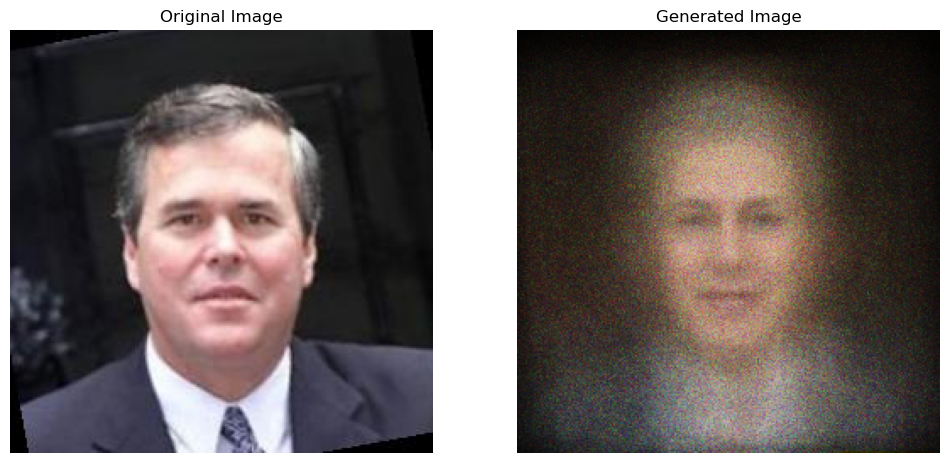

In [15]:
model.eval()
dataiter = iter(dataloader)
images, _ = next(dataiter)
random_image = images[random.randint(0, images.size(0) - 1)].to(device)
plt.figure(figsize=(12, 6))

# Displaying the original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(random_image.permute(1, 2, 0).cpu().numpy())
plt.axis('off')

with torch.no_grad():
    # Correctly flattening the image and passing it to the encoder
    flat_image = random_image.view(1, -1).to(device)  # Adding batch dimension and flattening
    mu, logvar = model.encode(flat_image)
    sample = model.reparameterize(mu, logvar)
    generated_image = model.decode(sample)

    # Reshaping the generated image to its original dimensions
    generated_image = generated_image.view(3, 250, 250)

# Displaying the generated image
plt.subplot(1, 2, 2)
plt.title("Generated Image")
plt.imshow(generated_image.permute(1, 2, 0).cpu().numpy())
plt.axis('off')

plt.show()


- Image Preparation: A random image is selected from the dataset and preprocessed for input into the VAE model.

- VAE Processing: The image is flattened, encoded to a latent representation, reparameterized, and then decoded to generate a new image.

- Visualization: Both the original and the generated image are displayed side-by-side for visual comparison.